Normalization check for the initial condition: $|\Psi(x,0)|**2=0.9999999999999998$


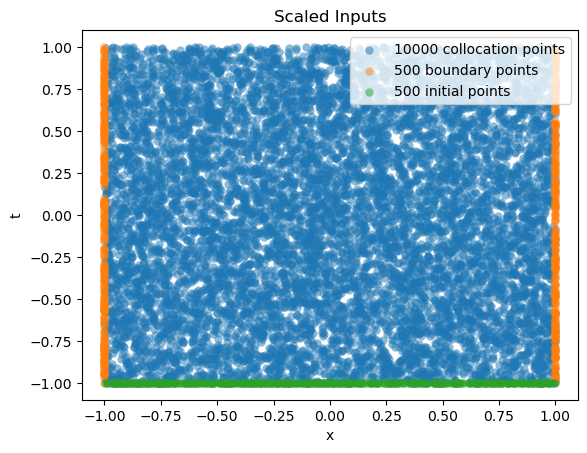

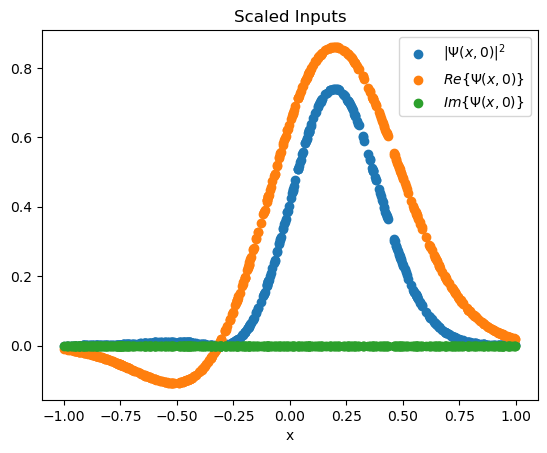

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# scaled interior points
x_f = scale_inputs(x_f, x_min, x_max)
t_f = scale_inputs(t_f, t_min, t_max)

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
# scaled boundary points
x_b = scale_inputs(x_b, x_min, x_max)
t_b = scale_inputs(t_b, t_min, t_max)

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i = scale_inputs(x_i, x_min, x_max)
t_i = scale_inputs(t_i, t_min, t_max)
# # normalized psi_i (Monte Carlo integration)
# norm = tf.math.sqrt(tf.reduce_mean(tf.math.abs(psi_i)**2) * (x_max-x_min))
# psi_i_Re = tf.math.real(psi_i) / norm
# psi_i_Im = tf.math.imag(psi_i) / norm

# normalized psi_i (Riemann sum approximation)
dx_i = (x_max - x_min) / N_i
norm = tf.math.sqrt(tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i)
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# verify normalization
norm_check = tf.reduce_sum(psi_i_Re**2 + psi_i_Im**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# grid for normalization penalty
N_grid = 200
x_grid = tf.linspace(x_min, x_max, N_grid)[:, None]  # shape (N_grid, 1)
x_grid = scale_inputs(x_grid, x_min, x_max)

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

# plotting initial condition
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'$|\Psi(x,0)|^2$')
plt.scatter(x_i, psi_i_Re, label=r'$Re\{\Psi(x,0)\}$')
plt.scatter(x_i, psi_i_Im, label=r'$Im\{\Psi(x,0)\}$')
plt.xlabel('x')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

In [2]:
# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, omega):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    potential = 0.5 * omega**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, w, x_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    omega = w

    f_u, f_v = pde_residual(model, x_f, t_f, omega)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v))

    uv_b = model(tf.concat([x_b, t_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2]))

    uv_i = model(tf.concat([x_i, t_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))
    
    # normalization penalty
    N_t = 3
    t_rand = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    norm_penalty_total = 0.0

    for t_val in tf.unstack(t_rand, axis=0):
        t_grid = tf.ones_like(x_grid) * t_val
        t_grid = scale_inputs(t_grid, t_min, t_max)

        uv_pred = model(tf.concat([x_grid, t_grid], axis=1))
        prob_density = tf.square(uv_pred[:, 0:1]) + tf.square(uv_pred[:, 1:2])

        # dx = (x_max - x_min) / tf.cast(tf.shape(x_grid)[0], DTYPE)
        dx = x_grid[1] - x_grid[0]
        norm = tf.reduce_sum(prob_density) * dx
        norm_penalty_total += tf.square(norm - 1.0)

    norm_penalty = norm_penalty_total / tf.cast(N_t, DTYPE)
    total_loss = loss_f + 10.0*loss_b + 10.0*loss_i + 10.0*norm_penalty

    return total_loss, (loss_f, 10.0*loss_b, 10.0*loss_i, 10.0*norm_penalty)

# Create the model
model = PINN(input_dim=2, mapping_size=512, scale=10.0)

# Save the model in Keras format
model_test_path = 'model_test_v5.keras'
model.save(model_test_path)
print(f"Model saved to {model_test_path}")

# Load the model
loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# Dummy input to build the model (batch size 1, input_dim = 2)
dummy_input = tf.concat([x_f[:5], t_f[:5]], axis=1)
_ = loaded_model(dummy_input)

loaded_model.summary()

Model saved to model_test_v5.keras


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_1         │ ?                      │         1,024 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (5, 512)               │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (5, 2)                 │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,818 (10.03 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,024 (8.00 KB)

In [3]:
#############################################################################

# Instantiate the Model
pinn = PINN(input_dim=2, mapping_size=512, scale=10.0)

# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.9
decay_steps = 2000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega, x_grid):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, norm_penalty) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), omega, x_grid)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, norm_penalty)

Epoch 0: Loss = 1.16324e+04 (f = 1.162e+04,               b = 5.491e+00, i = 6.233e+00), norm_p = 1.074e+00


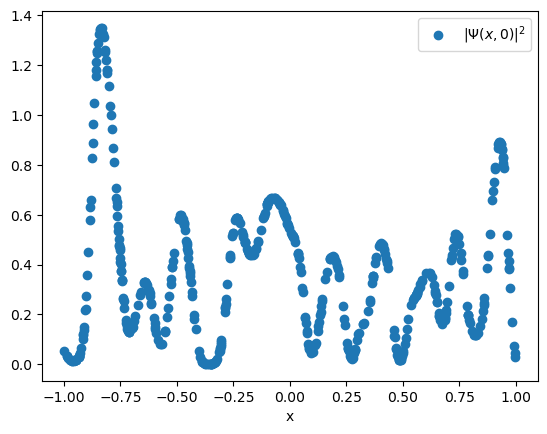

Best model saved to best_model_v0.keras at epoch 0
Best model saved to best_model_v0.keras at epoch 2
Best model saved to best_model_v0.keras at epoch 3
Best model saved to best_model_v0.keras at epoch 4
Best model saved to best_model_v0.keras at epoch 5
Best model saved to best_model_v0.keras at epoch 6
Best model saved to best_model_v0.keras at epoch 7
Best model saved to best_model_v0.keras at epoch 8
Best model saved to best_model_v0.keras at epoch 9
Best model saved to best_model_v0.keras at epoch 10
Best model saved to best_model_v0.keras at epoch 11
Best model saved to best_model_v0.keras at epoch 12
Best model saved to best_model_v0.keras at epoch 13
Best model saved to best_model_v0.keras at epoch 14
Best model saved to best_model_v0.keras at epoch 15
Best model saved to best_model_v0.keras at epoch 16
Best model saved to best_model_v0.keras at epoch 17
Best model saved to best_model_v0.keras at epoch 18
Best model saved to best_model_v0.keras at epoch 19
Best model saved to b

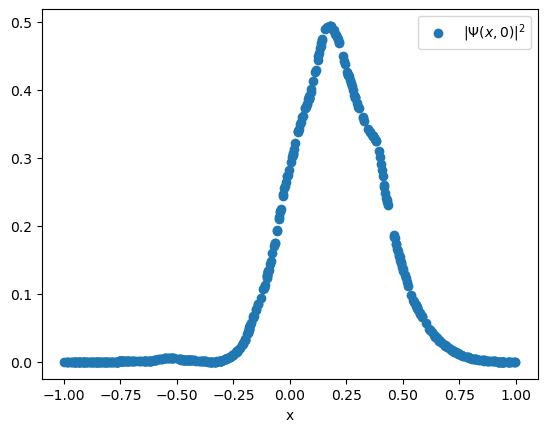

Estimated time remaining: 0:02:43
Best model saved to best_model_v0.keras at epoch 1015
Best model saved to best_model_v0.keras at epoch 1016
Best model saved to best_model_v0.keras at epoch 1017
Best model saved to best_model_v0.keras at epoch 1121
Best model saved to best_model_v0.keras at epoch 1175
Best model saved to best_model_v0.keras at epoch 1210
Best model saved to best_model_v0.keras at epoch 1237
Best model saved to best_model_v0.keras at epoch 1329
Best model saved to best_model_v0.keras at epoch 1331
Best model saved to best_model_v0.keras at epoch 1335
Best model saved to best_model_v0.keras at epoch 1415
Best model saved to best_model_v0.keras at epoch 1457
Best model saved to best_model_v0.keras at epoch 1458
Best model saved to best_model_v0.keras at epoch 1459
Best model saved to best_model_v0.keras at epoch 1464
Best model saved to best_model_v0.keras at epoch 1632
Best model saved to best_model_v0.keras at epoch 1643
Best model saved to best_model_v0.keras at epoch

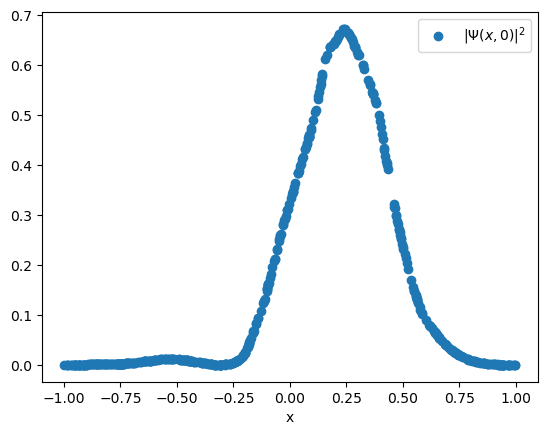

Estimated time remaining: 0:45:29
Best model saved to best_model_v0.keras at epoch 2146
Best model saved to best_model_v0.keras at epoch 2149
Best model saved to best_model_v0.keras at epoch 2150
Best model saved to best_model_v0.keras at epoch 2161
Best model saved to best_model_v0.keras at epoch 2162
Best model saved to best_model_v0.keras at epoch 2235
Best model saved to best_model_v0.keras at epoch 2236
Best model saved to best_model_v0.keras at epoch 2238
Best model saved to best_model_v0.keras at epoch 2239
Best model saved to best_model_v0.keras at epoch 2240
Best model saved to best_model_v0.keras at epoch 2241
Best model saved to best_model_v0.keras at epoch 2248
Best model saved to best_model_v0.keras at epoch 2249
Best model saved to best_model_v0.keras at epoch 2509
Best model saved to best_model_v0.keras at epoch 2510
Best model saved to best_model_v0.keras at epoch 2511
Best model saved to best_model_v0.keras at epoch 2512
Best model saved to best_model_v0.keras at epoch

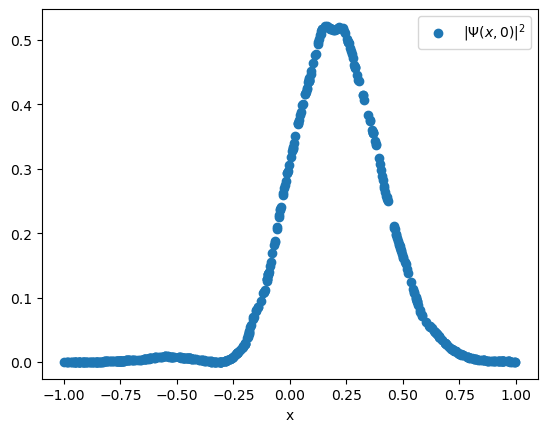

Estimated time remaining: 0:44:00
Best model saved to best_model_v0.keras at epoch 3068
Best model saved to best_model_v0.keras at epoch 3605
Best model saved to best_model_v0.keras at epoch 3960
Best model saved to best_model_v0.keras at epoch 3961
Best model saved to best_model_v0.keras at epoch 3988
Best model saved to best_model_v0.keras at epoch 3990
Best model saved to best_model_v0.keras at epoch 3994
Epoch 4000: Loss = 1.05591e-02 (f = 8.206e-03,               b = 2.460e-04, i = 7.569e-04), norm_p = 1.351e-03


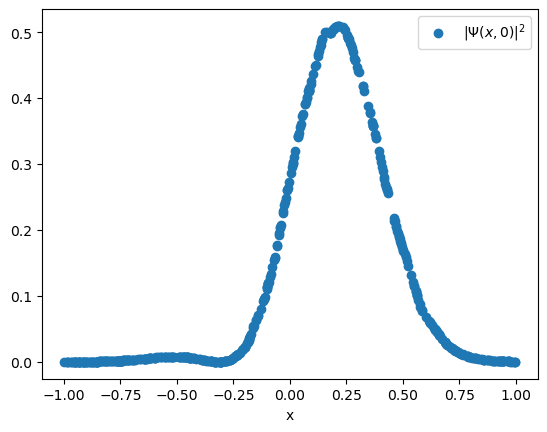

Estimated time remaining: 0:00:41
Best model saved to best_model_v0.keras at epoch 4022
Best model saved to best_model_v0.keras at epoch 4026
Best model saved to best_model_v0.keras at epoch 4029
Best model saved to best_model_v0.keras at epoch 4832
Epoch 5000: Loss = 3.97267e-02 (f = 1.743e-02,               b = 6.557e-04, i = 1.583e-03), norm_p = 2.006e-02


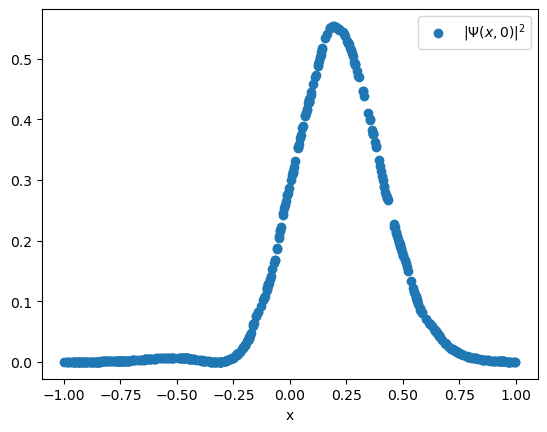

Estimated time remaining: 0:23:14


KeyboardInterrupt: 

In [4]:
#############################################################################

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 1000
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm_penalty": []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v0.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, norm_penalty) = train_step(pinn, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, omega, x_grid)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm_penalty"].append(norm_penalty.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, \
              b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}), norm_p = {norm_penalty.numpy().item():.3e}")

        X = tf.concat([x_i, t_i], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$')
        plt.xlabel('x')
        plt.legend()
        plt.show()

        if epoch > 0:
            elapsed = time.time() - start_time
            eta = (elapsed/epoch) * (epoch + patience_counter)
            eta_formatted = str(datetime.timedelta(seconds=int(eta-elapsed)))
            print(f"Estimated time remaining: {eta_formatted}")
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm_penalty"], label="Norm Penalty")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

# Check prediction consistency
x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float64)
x_test = scale_inputs(x_test, x_min, x_max)
t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float64)
t_test = scale_inputs(t_test, t_min, t_max)

x_test_tensor = tf.convert_to_tensor(x_test)
t_test_tensor = tf.convert_to_tensor(t_test)

original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
    print("Predictions do not match after loading!")
else:
    print("Predictions match.")

In [ ]:
# # Plot the Loss vs. Epochs
# plt.plot(train_loss_results["total"], label="Total Loss")
# plt.plot(train_loss_results["pde"], label="PDE Loss")
# plt.plot(train_loss_results["boundary"], label="Boundary Loss")
# plt.plot(train_loss_results["initial"], label="Initial Loss")
# plt.plot(train_loss_results["norm_penalty"], label="Norm Penalty")
# plt.yscale("log")
# plt.legend()
# plt.title("Loss Components During Training")
# plt.xlabel("Epoch")
# plt.ylabel("Loss (log scale)")
# plt.grid(True)
# plt.show()

# # Save original weights
# original_weights = pinn.get_weights()

# # Load the model
# loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# # Check if the weights match
# loaded_weights = loaded_pinn.get_weights()

# for orig, loaded in zip(original_weights, loaded_weights):
#     if not np.array_equal(orig, loaded):
#         print("Weights do not match after loading!")
#     else:
#         print("Weights match.")

# # Check prediction consistency
# x_test = np.linspace(x_min, x_max, 100).reshape(-1,1).astype(np.float64)
# x_test = scale_inputs(x_test, x_min, x_max)
# t_test = np.linspace(t_min, t_max, 100).reshape(-1,1).astype(np.float64)
# t_test = scale_inputs(t_test, t_min, t_max)

# x_test_tensor = tf.convert_to_tensor(x_test)
# t_test_tensor = tf.convert_to_tensor(t_test)

# original_prediction = pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()
# loaded_prediction = loaded_pinn(tf.concat([x_test_tensor, t_test_tensor], axis=1)).numpy()

# if not np.allclose(original_prediction, loaded_prediction, atol=1e-5):
#     print("Predictions do not match after loading!")
# else:
#     print("Predictions match.")

In [ ]:
# from scipy.optimize import minimize

# # 1. Helper functions for weights packing/unpacking
# def get_weights(model):
#     weights = model.get_weights()
#     return np.concatenate([w.flatten() for w in weights])

# def set_weights(model, flat_weights):
#     shapes = [w.shape for w in model.get_weights()]
#     new_weights = []
#     idx = 0
#     for shape in shapes:
#         size = np.prod(shape)
#         new_weights.append(flat_weights[idx:idx+size].reshape(shape))
#         idx += size
#     model.set_weights(new_weights)

# # 2. Loss and gradient function wrapper for SciPy

# lbfgs_losses = []  # global list to collect L-BFGS-B loss values

# def loss_callback(weights):
#     loss_value, _ = scipy_loss_and_gradients(weights)
#     print(f"L-BFGS-B iteration: Loss = {loss_value.numpy():.6e}")

# def scipy_loss_and_gradients(flat_weights):
#     # Set weights
#     set_weights(loaded_model, flat_weights)

#     # Use tf.GradientTape for gradient computation
#     with tf.GradientTape() as tape:
#         loss_value, _ = loss_fn(
#             pinn,
#             (x_f, t_f),
#             (x_b, t_b),
#             (x_i, t_i, psi_i),
#             omega
#         )
#     gradients = tape.gradient(loss_value, loaded_model.trainable_variables)

#     # Flatten gradients to 1D array
#     grad_flat = np.concatenate([g.numpy().flatten() for g in gradients if g is not None])

#     # Store current loss value for plotting
#     lbfgs_losses.append(loss_value.numpy())

#     return loss_value.numpy().astype(np.float64), grad_flat.astype(np.float64)

# # 3. Run L-BFGS-B optimization
# print("Starting L-BFGS-B optimization...")
# initial_weights = get_weights(loaded_model)
# result = minimize(fun=scipy_loss_and_gradients,
#                   x0=initial_weights,
#                   method='L-BFGS-B',
#                   jac=True,
#                   callback=loss_callback,
#                   options={'maxiter': 20000, 'maxcor': 50, 'ftol': 1e-10, 'gtol': 1e-10, 'disp': True})

# # 4. Set the model weights to the result
# set_weights(loaded_model, result.x)
# print("L-BFGS-B optimization completed.")

# # Save the model in Keras format
# model_save_path_lbfgsb = 'model_v4_lbfgsb.keras'
# pinn.save(model_save_path_lbfgsb)
# print(f"Model saved to {model_save_path_lbfgsb}")

In [ ]:
################################################## Loading the model ###########################################################3

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# inputs
omega = tf.constant(1.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = tf.constant(-np.pi, dtype=DTYPE), tf.constant(np.pi, dtype=DTYPE)
t_min, t_max = tf.constant(0.0, dtype=DTYPE), tf.constant(2.0*np.pi, dtype=DTYPE)

def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# initial condition
@tf.function
def psi_init(x, omega, pi):
    u_0 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2)
    u_1 = (omega/pi)**0.25 * tf.math.exp(-0.5*omega*x**2) * x * tf.math.sqrt(omega)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 400, 500

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
# scaled interior points
x_f_scaled = scale_inputs(x_f, x_min, x_max)
t_f_scaled = scale_inputs(t_f, t_min, t_max)

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
# scaled boundary points
x_b_scaled = scale_inputs(x_b, x_min, x_max)
t_b_scaled = scale_inputs(t_b, t_min, t_max)

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, omega, pi), tf.complex128)
# scaled initial points
x_i_scaled = scale_inputs(x_i, x_min, x_max)
t_i_scaled = scale_inputs(t_i, t_min, t_max)
# normalized psi_i
norm = tf.math.sqrt(tf.reduce_mean(tf.math.abs(psi_i)**2) * (x_max-x_min))
psi_i_Re = tf.math.real(psi_i) / norm
psi_i_Im = tf.math.imag(psi_i) / norm

# define Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
##############################################################################

# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=2, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model
loaded_model = tf.keras.models.load_model('model_v4.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

# Create a contour plot
x_plot = np.linspace(x_min, x_max, 100)
t_plot = np.linspace(t_min, t_max, 100)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

input = tf.concat([x_f_scaled, t_f_scaled], axis=1)
uv = loaded_model(input)
u, v = uv[:, 0], uv[:, 1]
density = u**2 + v**2
density_grid = tf.reshape(density, X_grid.shape)

# # Convert tensors to numpy for plotting
# X_plot_np = X_grid.np()
# T_plot_np = T_grid.np()
density_grid_np = density_grid.numpy()


# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_grid_np, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Predicted $|\Psi(x,t)|^2$')
plt.tight_layout()
plt.show()

# test points
t_test = tf.keras.ops.full_like(x_i, 0.2, dtype=DTYPE)
t_test_scaled = scale_inputs(t_test, t_min, t_max)

X = tf.concat([x_i_scaled, t_i_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

X_test = tf.concat([x_i_scaled, t_test_scaled], axis=1)
uv = loaded_model(X_test)
u, v = uv[:, 0:1], uv[:, 1:2]
density_test = u**2 + v**2

plt.scatter(x_i, density, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_test, label=f'Predicted $|\Psi(x,{t_test[0,0].numpy()})|^2$')
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

X = tf.concat([x_b_scaled, t_b_scaled], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
density = u**2 + v**2

density_bounds = tf.keras.ops.full_like(t_b, 0.0, dtype=DTYPE)

plt.scatter(t_b, density, label=r'Predicted $|\Psi(0,t)|^2$')
plt.scatter(t_b, density_bounds, label=r'Expected $|\Psi(0,t)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()